In [30]:
import os
import numpy as np
import pandas as pd
import math
import data
import random
import torch
from model import SEDD4REC
import utils
from model.ema import ExponentialMovingAverage
import graph_lib
import noise_lib
import sampling
import utils
from load_model import load_model

In [31]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [32]:
import yaml
from omegaconf import OmegaConf
with open('./configs/config_sample.yaml', 'r') as f:
    raw_dict = yaml.safe_load(f)
raw_dict["model"]["hidden_size"] = 256
raw_dict["model"]["cond_dim"] = 256
raw_dict["model"]["length"] = 10
raw_dict["model"]["n_blocks"] = 1
raw_dict["model"]["n_heads"] = 2
raw_dict["model"]["scale_by_sigma"] = False
raw_dict["model"]["dropout"] = 0.1
raw_dict["model"]["score_flag"] = True
raw_dict["model"]["score_method"] = "oricos"
cfg = OmegaConf.create(raw_dict)
cfg.training.data="Beauty"
cfg.graph.type="hybrid" 
# cfg.graph.type="adaptive" 
cfg.graph.gamma=0.9999
cfg.graph.is_disliked_item=True 
cfg.training.nonpreference_user_ratio=0.1 
cfg.optim.lr=0.001 
cfg.loss_type="score_entropy" 
cfg.noise = OmegaConf.create({
    "type": "geometric",
    "sigma_min": 1e-3,
    "sigma_max": 1
})

In [5]:
cfg.noise.sigma_min

0.001

In [6]:
cfg.model.score_flag

True

In [33]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg.training.data = "Steam"
train_loader, val_loader, test_loader = data.get_seqdataloader(cfg)
setup_seed(100)
graph = graph_lib.get_graph(cfg, device)
noise = noise_lib.get_noise(cfg).to(device)
score_model = SEDD4REC(cfg).to(device)
ema = ExponentialMovingAverage(score_model.parameters(), decay=cfg.training.ema)
ckpt_dir = os.path.join("./checkpoints-meta", f"{cfg.training.data}", f"checkpoint_{cfg.graph.type}.pth")

loaded_state = torch.load(ckpt_dir, map_location=device)
score_model.load_state_dict(loaded_state['model'])
ema.load_state_dict(loaded_state['ema'])
ema.store(score_model.parameters())
ema.copy_to(score_model.parameters())

True
9266


In [34]:
HR_w = []
NDCG_w = []
T = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 50, 100, 200]
for i in range(len(T)):
    sampling_fn = sampling.get_pc_sampler(graph=graph,
                                 noise=noise,
                                 predictor="analytic",
                                 steps=T[i],
                                 personalization_strength=10,
                                 denoise=True,
                                 eps=1e-5,
                                 device=device)
    hr_list, ndcg_list = utils.evaluate_loader(score_model, sampling_fn, test_loader, device)
    HR_w.append(hr_list)
    NDCG_w.append(ndcg_list)

ACC        ACC        ACC        
0.019009   0.019009   0.019009  
HR@5       HR@10      HR@20      HR@50     
0.059017   0.091983   0.139916   0.229461  
NDCG@5     NDCG@10    NDCG@20    NDCG@50   
0.039176   0.049726   0.061778   0.079457  
MRR@5      MRR@10     MRR@20     MRR@50    
0.032682   0.036972   0.040245   0.043047  
ACC        ACC        ACC        
0.018996   0.018996   0.018996  
HR@5       HR@10      HR@20      HR@50     
0.059054   0.091872   0.139816   0.229461  
NDCG@5     NDCG@10    NDCG@20    NDCG@50   
0.039193   0.049704   0.061770   0.079475  
MRR@5      MRR@10     MRR@20     MRR@50    
0.032692   0.036971   0.040253   0.043062  
ACC        ACC        ACC        
0.019133   0.019133   0.019133  
HR@5       HR@10      HR@20      HR@50     
0.059365   0.092456   0.140550   0.229337  
NDCG@5     NDCG@10    NDCG@20    NDCG@50   
0.039477   0.050069   0.062160   0.079690  
MRR@5      MRR@10     MRR@20     MRR@50    
0.032962   0.037270   0.040553   0.043331  
ACC    

In [36]:
HR_5 = [round(HR_w[i][1], 4) for i in range(len(T))]
HR_10 = [round(HR_w[i][2], 4) for i in range(len(T))]
NDCG_5 = [round(NDCG_w[i][1], 4) for i in range(len(T))]
NDCG_10 = [round(NDCG_w[i][2], 4) for i in range(len(T))]
HR_20 = [round(HR_w[i][3], 4) for i in range(len(T))]
NDCG_20 = [round(NDCG_w[i][3], 4) for i in range(len(T))]

In [35]:
HR_5 = [round(HR_w[i][1], 4) for i in range(0,21)]
HR_10 = [round(HR_w[i][2], 4) for i in range(0,21)]
NDCG_5 = [round(NDCG_w[i][1], 4) for i in range(0,21)]
NDCG_10 = [round(NDCG_w[i][2], 4) for i in range(0,21)]
HR_20 = [round(HR_w[i][3], 4) for i in range(0,21)]
NDCG_20 = [round(NDCG_w[i][3], 4) for i in range(0,21)]

IndexError: list index out of range

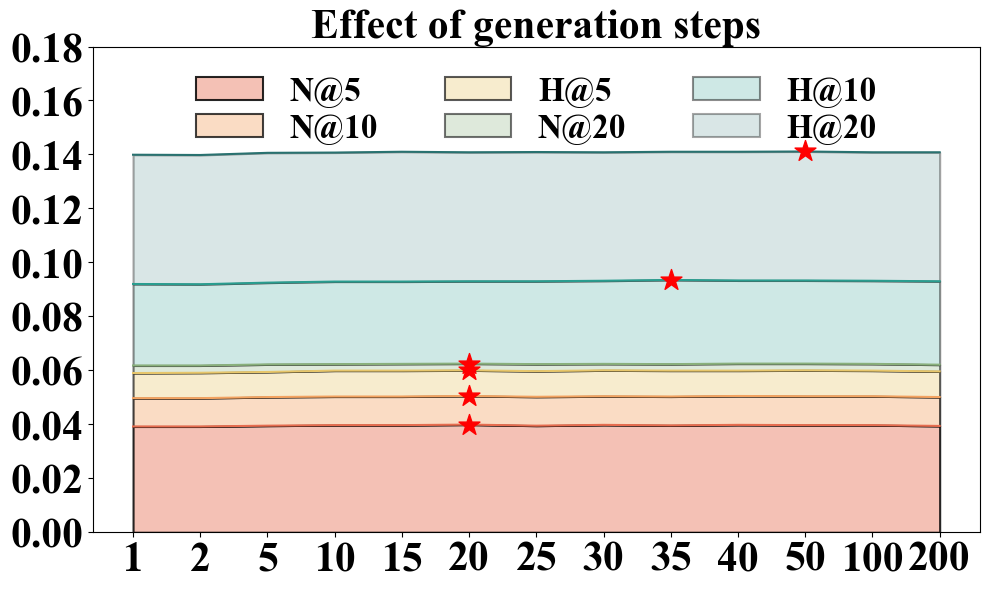

In [41]:
# Re-import necessary libraries after kernel reset
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb

plt.style.use('seaborn-v0_8-muted')
# 设置图形风格
#sns.set(style="ticks")
import matplotlib.font_manager as fm
fm.fontManager.addfont('../../ours_DiT/fonts/times.ttf')
fm.fontManager.addfont('../../ours_DiT/fonts/timesbd.ttf')
fm.fontManager.addfont('../../ours_DiT/fonts/timesbi.ttf')
fm.fontManager.addfont('../../ours_DiT/fonts/timesi.ttf')
plt.rc('font',family='Times New Roman', weight='bold')

# Parameters (x-axis)
algs = list(range(len(T)))
x_labels = T
# Metrics (y-axis, 6 components)
# [0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999]
stats_ls = []
for i in range(len(T)):
    dl = []
    dl.append(HR_5[i])
    dl.append(HR_10[i])
    dl.append(HR_20[i])
    dl.append(NDCG_5[i])
    dl.append(NDCG_10[i])
    dl.append(NDCG_20[i])
    stats_ls.append(dl)
    

# stats_ls = [
#     [0.0609, 0.0933, 0.1405, 0.0400, 0.0505, 0.0623],
#     [0.0615, 0.0935, 0.1413, 0.0406, 0.0508, 0.0628],
#     [0.0595, 0.0929, 0.1398, 0.0396, 0.0503, 0.0621],
#     [0.0607, 0.0930, 0.1407, 0.0400, 0.0504, 0.0624],
#     [0.0606, 0.0937, 0.1397, 0.0400, 0.0507, 0.0622],
#     [0.0593, 0.0914, 0.1383, 0.0392, 0.0495, 0.0613]
#     ]

labels = ['H@5', 'H@10', 'H@20', 'N@5', 'N@10', 'N@20']

# Sort and reorder
new_order = [3, 4, 0, 5, 1, 2]
stats_arr = np.array(stats_ls)[:, new_order]
labels = [labels[i] for i in new_order]

# Generate base colors from colormap
colors = plt.cm.coolwarm(np.linspace(0, 1, len(stats_ls[0])))

# Create deeper line colors
def darken_color(color, amount=0.6):
    r, g, b = to_rgb(color)
    return (r * amount, g * amount, b * amount)

line_colors = [darken_color(c, 0.8) for c in colors]

def lighten_color(color, amount=0.2):
    """
    Lightens the given color by mixing it with white.

    Parameters:
    - color: a matplotlib color string or RGB tuple
    - amount: 0 returns original color, 1 returns white
    """
    r, g, b = to_rgb(color)
    return (1 - amount) * r + amount, (1 - amount) * g + amount, (1 - amount) * b + amount

line_colors = ['#e66d50','#f3a361','#e7c66b','#8ab07c','#299d8f', '#297270']
colors = [lighten_color(c, 0.5) for c in line_colors]

# Transpose to shape (6, 10) for stackplot (layers x steps)
data = stats_arr.T

# Plot
plt.figure(figsize=(10, 6))

for i in range(data.shape[0]):
    y_lower = data[i - 1] if i > 0 else np.zeros_like(algs)
    y_upper = data[i]

    plt.fill_between(algs, y_upper, y_lower,
                     color=colors[i], edgecolor='black', linewidth=1.5,
                     label=labels[i], alpha=0.85 - i * 0.1)

    plt.plot(algs, y_upper, color=line_colors[i], linewidth=1.5)

    max_idx = np.argmax(y_upper)
    plt.scatter([algs[max_idx]], [y_upper[max_idx]], color='red', s=249, marker='*', zorder=6)

# plt.xticks(x_labels, labels=[p for p in x_labels], fontsize=16)
plt.xticks(algs, [str(label) for label in x_labels],fontsize=30)
# f"{p:.2f}"
plt.ylim(0, 0.18)
plt.yticks(fontsize=30)
# plt.ylabel('Metric Value', fontsize=12)
plt.title('Effect of generation steps', fontsize=30, fontweight="bold")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), labelspacing=0.2, ncol=len(labels)/2, fontsize=24, frameon=False)
plt.tight_layout()
plt.savefig("./steam_ana_TG_adaptive.pdf", bbox_inches='tight')

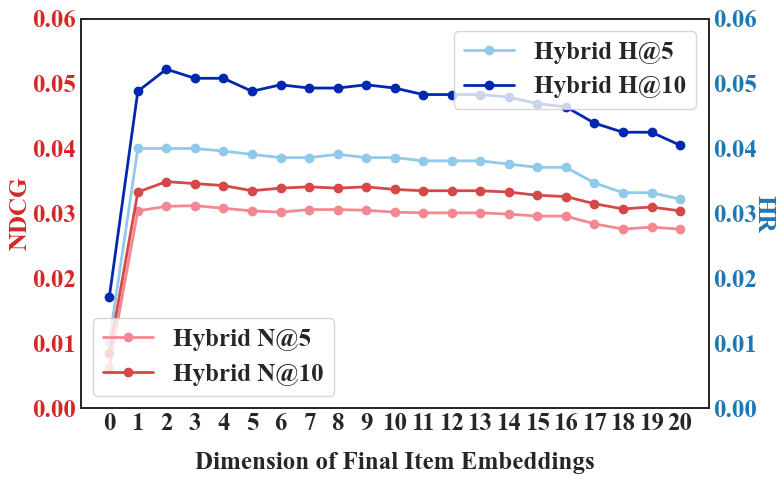

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图形风格
sns.set(style="ticks")
import matplotlib.font_manager as fm
fm.fontManager.addfont('../../ours_DiT/fonts/times.ttf')
fm.fontManager.addfont('../../ours_DiT/fonts/timesbd.ttf')
fm.fontManager.addfont('../../ours_DiT/fonts/timesbi.ttf')
fm.fontManager.addfont('../../ours_DiT/fonts/timesi.ttf')
plt.rc('font',family='Times New Roman', weight='bold')

# data 
S = list(range(0,21))
Dim = list(range(0,21))
HR_5 = [round(HR_w[i][1], 4) for i in range(0,21)]
HR_10 = [round(HR_w[i][2], 4) for i in range(0,21)]
HR_20 = [round(HR_w[i][3], 4) for i in range(0,21)]
NDCG_5 = [round(NDCG_w[i][1], 4) for i in range(0,21)]
NDCG_10 = [round(NDCG_w[i][2], 4) for i in range(0,21)]
NDCG_20 = [round(NDCG_w[i][3], 4) for i in range(0,21)]

index = 5

fig, ax1 = plt.subplots(figsize=(8, 5))

# 主y轴 (ax1) - 只绘制第一个元素
ax1.plot(S, HR_5, label="Hybrid H@5", color='#91CAE8', marker='o', linewidth=2)
ax1.plot(S, HR_10, label="Hybrid H@10", color='#0027AF', marker='o', linewidth=2)

ax1.set_ylabel('NDCG', fontweight="bold", fontsize=18, labelpad=0, color="tab:red")
ax1.set_ylim(0.00, 0.06)
ax1.set_xlabel('Dimension of Final Item Embeddings',fontweight="bold",labelpad=12, fontsize=18)
ticks = ax1.get_yticks()
f_ticks = [f"{tick:.2f}" for tick in ticks]
ax1.set_yticks(ticks)  
ax1.set_yticklabels(f_ticks, fontsize=18)

# 次y轴 (ax2) - 绘制剩余元素
ax2 = ax1.twinx()
ax2.plot(S, NDCG_5, color='#F48892', label="Hybrid N@5", marker='o', linewidth=2)
ax2.plot(S, NDCG_10, color='#D44848', label="Hybrid N@10", marker='o', linewidth=2)
ax2.set_ylim(0.00, 0.06)
ax2.set_ylabel('HR', fontweight="bold",fontsize=18, rotation=270, labelpad=12, color="tab:blue")

ticks = ax2.get_yticks()
f_ticks = [f"{tick:.2f}" for tick in ticks]
ax2.set_yticks(ticks)  
ax2.set_yticklabels(f_ticks, fontsize=18)

# 设置x轴标签和图例
#plt.xlabel('Datasets', fontweight="bold")
plt.xticks(ticks=S,labels=Dim,color="black")
ax1.set_xticklabels(Dim, fontsize=18)
ax1.tick_params(axis='y', length=0, labelcolor="tab:red")
ax1.tick_params(axis='x', length=0)
ax2.tick_params(axis='y', length=0, labelcolor="tab:blue")
ax2.legend(loc="lower left", ncol=1, fontsize=18)
ax1.legend(loc="upper right", ncol=1, fontsize=18)
#ax2.legend().set_visible(False)

plt.tight_layout()
#plt.savefig("./images/dim_item_embs.pdf", bbox_inches='tight')
plt.show()

In [13]:
HR_w = []
NDCG_w = []
for i in range(1,51):
    sampling_fn = sampling.get_pc_sampler(graph=graph,
                            noise=noise,
                            predictor="analytic",
                            steps=i,
                            personalization_strength=3,
                            denoise=True,
                            eps=1e-5,
                            device=device)
    hr_list, ndcg_list = utils.evaluate_loader(score_model, sampling_fn, test_loader, device)
    HR_w.append(hr_list)
    NDCG_w.append(ndcg_list)

ACC        ACC        ACC        
0.021973   0.021973   0.021973  
HR@5       HR@10      HR@20      HR@50     
0.039062   0.050781   0.063477   0.081543  
NDCG@5     NDCG@10    NDCG@20    NDCG@50   
0.030679   0.034462   0.037635   0.041218  
MRR@5      MRR@10     MRR@20     MRR@50    
0.027930   0.029487   0.030339   0.030913  
ACC        ACC        ACC        
0.021973   0.021973   0.021973  
HR@5       HR@10      HR@20      HR@50     
0.038574   0.050781   0.062988   0.082031  
NDCG@5     NDCG@10    NDCG@20    NDCG@50   
0.030477   0.034435   0.037491   0.041273  
MRR@5      MRR@10     MRR@20     MRR@50    
0.027816   0.029454   0.030278   0.030886  
ACC        ACC        ACC        
0.021973   0.021973   0.021973  
HR@5       HR@10      HR@20      HR@50     
0.039062   0.050781   0.062988   0.082031  
NDCG@5     NDCG@10    NDCG@20    NDCG@50   
0.030615   0.034398   0.037439   0.041228  
MRR@5      MRR@10     MRR@20     MRR@50    
0.027848   0.029405   0.030217   0.030829  
ACC    

In [5]:
sampling_fn = sampling.get_full_sampler(graph=graph,
                                noise=noise,
                                predictor="analytic",
                                steps=20,
                                personalization_strength=3,
                                denoise=True,
                                eps=1e-5,
                                device=device)
KL_list = utils.evaluate_sample_KL(score_model, sampling_fn, test_loader, device)
display(KL_list)

tensor([8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2618e-05, 8.2626e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2613e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2623e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2617e-05, 8.2619e-05, 8.2619e-05, 8.2619e-05,
        8.2619e-05, 8.2619e-05, 8.2619e-

[tensor(9.3949, device='cuda:0'),
 tensor(9.6080, device='cuda:0'),
 tensor(9.6414, device='cuda:0'),
 tensor(9.6822, device='cuda:0'),
 tensor(9.7234, device='cuda:0'),
 tensor(9.7475, device='cuda:0'),
 tensor(9.7539, device='cuda:0'),
 tensor(9.7874, device='cuda:0'),
 tensor(9.7809, device='cuda:0'),
 tensor(9.7811, device='cuda:0'),
 tensor(9.7639, device='cuda:0'),
 tensor(9.7492, device='cuda:0'),
 tensor(9.6954, device='cuda:0'),
 tensor(9.6720, device='cuda:0'),
 tensor(9.6432, device='cuda:0'),
 tensor(9.5618, device='cuda:0'),
 tensor(9.5127, device='cuda:0'),
 tensor(9.4566, device='cuda:0'),
 tensor(9.4276, device='cuda:0'),
 tensor(9.3961, device='cuda:0'),
 tensor(9.3942, device='cuda:0')]

In [6]:
import pickle
with open('draw_data/full_sample_probs_list.pkl', 'rb') as f:
    full_sample_probs = pickle.load(f)

In [7]:
len(full_sample_probs)

21

In [9]:
full_sample_probs[0].shape

torch.Size([256, 1, 12102])

In [6]:
len([])

0